In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt

In [3]:
def generate_elliptical_galaxy(shape, center, semimajor_axis, semiminor_axis, position_angle, intensity):
    y, x = np.ogrid[:shape[0], :shape[1]]
    x_centered = x - center[0]
    y_centered = y - center[1]
    theta = np.radians(position_angle)
    x_rotated = x_centered * np.cos(theta) - y_centered * np.sin(theta)
    y_rotated = x_centered * np.sin(theta) + y_centered * np.cos(theta)
    galaxy = np.exp(-((x_rotated / semimajor_axis)**2 + (y_rotated / semiminor_axis)**2) / 2.0) * intensity
    return galaxy


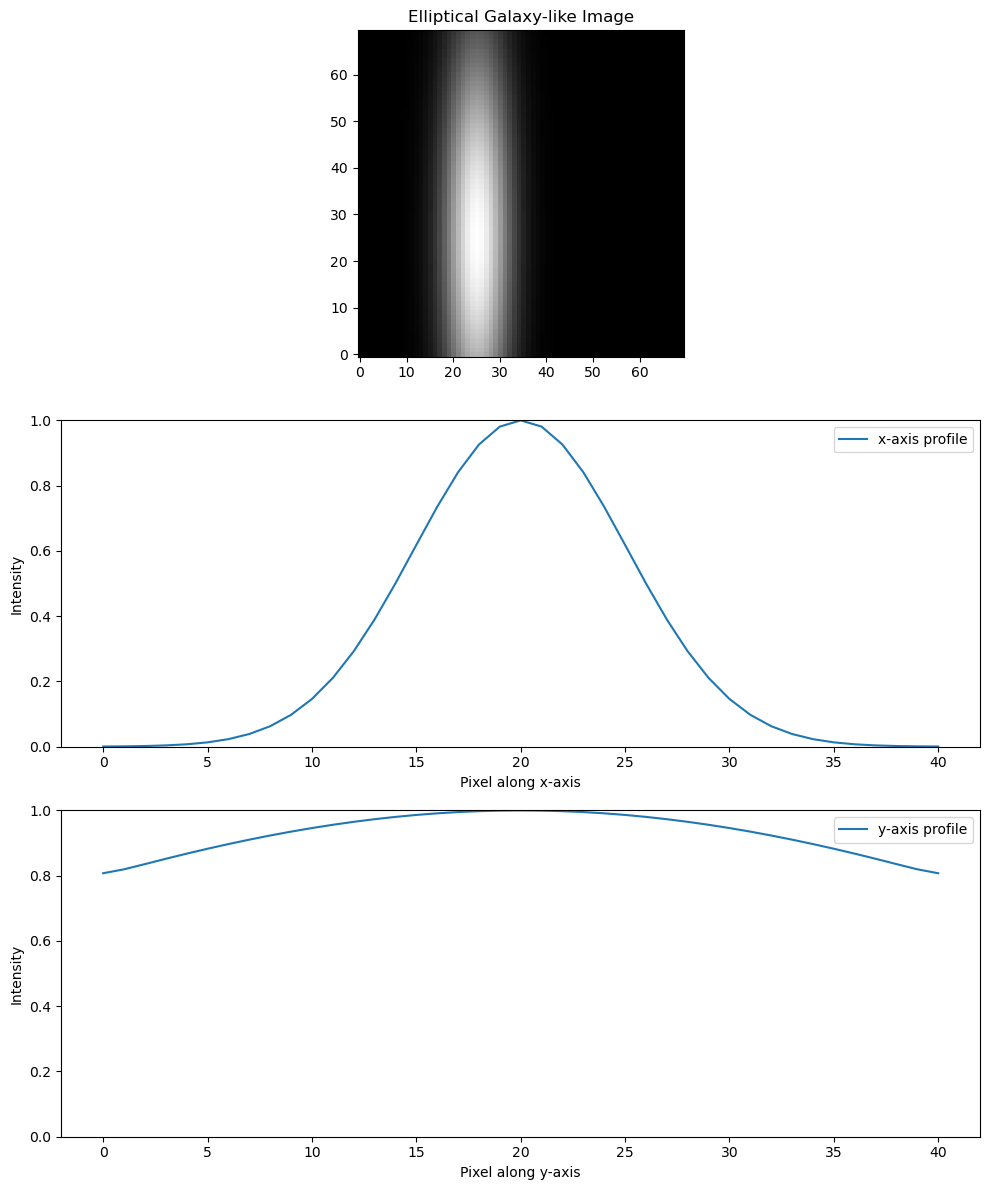

In [13]:
def extract_light_profile(image, target_coord, box_size, direction, sigma=1.0, sigma_clip_threshold=5.0):
    x, y = target_coord
    box_half_size = box_size
    box_x_start = max(0, x - box_half_size)
    box_x_end = min(image.shape[1], x + box_half_size + 1)
    box_y_start = max(0, y - box_half_size)
    box_y_end = min(image.shape[0], y + box_half_size + 1)

    box = image[box_y_start:box_y_end, box_x_start:box_x_end]

    if direction == 'x':
        profile = np.sum(box, axis=0)
    elif direction == 'y':
        profile = np.sum(box, axis=1)
    else:
        raise ValueError("Invalid direction. Use 'x' or 'y'.")

    # Sigma clipping
    clipped_profile = sigma_clip(profile, sigma=sigma_clip_threshold, masked=True)

    smoothed_profile = gaussian_filter1d(clipped_profile, sigma=sigma, mode='nearest')
    normalized_profile = smoothed_profile / np.max(smoothed_profile)

    return normalized_profile

# Set the size of the image
image_shape = (70, 70)

# Set the properties of the elliptical galaxy
galaxy_center = (25, 25)
semimajor_axis = 30
semiminor_axis = 5
position_angle = 90  # in degrees
galaxy_intensity = 100.0

# Generate the elliptical galaxy image
elliptical_galaxy = generate_elliptical_galaxy(
    image_shape, galaxy_center, semimajor_axis, semiminor_axis, position_angle, galaxy_intensity
)

# Extract 1D profile along x-axis using the provided function
target_coordinate = galaxy_center
box_size = 20
direction_to_study = 'x'
sigma_value = 1.0
sigma_clip_threshold = 5.0

profile_x_elliptical = extract_light_profile(
    elliptical_galaxy, target_coordinate, box_size, direction_to_study,
    sigma=sigma_value, sigma_clip_threshold=sigma_clip_threshold
)

# Extract 1D profile along y-axis using the provided function
direction_to_study = 'y'

profile_y_elliptical = extract_light_profile(
    elliptical_galaxy, target_coordinate, box_size, direction_to_study,
    sigma=sigma_value, sigma_clip_threshold=sigma_clip_threshold
)

# Plot the original elliptical galaxy image and the extracted profiles
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

axes[0].imshow(elliptical_galaxy, cmap='gray', origin='lower')
axes[0].set_title('Elliptical Galaxy-like Image')

axes[1].plot(profile_x_elliptical, label='x-axis profile')
axes[1].legend()
axes[1].set_xlabel('Pixel along x-axis')
axes[1].set_ylabel('Intensity')
axes[1].set_ylim(0, 1)

axes[2].plot(profile_y_elliptical, label='y-axis profile')
axes[2].legend()
axes[2].set_xlabel('Pixel along y-axis')
axes[2].set_ylabel('Intensity')
axes[2].set_ylim(0, 1)
plt.tight_layout()
plt.show()


In [6]:
profile_y_elliptical

array([0.80752859, 0.81960164, 0.83552194, 0.85182469, 0.8675654 ,
       0.88261934, 0.89693844, 0.91047878, 0.92319831, 0.93505716,
       0.94601779, 0.95604523, 0.9651072 , 0.97317436, 0.98022043,
       0.98622232, 0.99116028, 0.995018  , 0.99778271, 0.99944521,
       1.        , 0.99944521, 0.99778271, 0.995018  , 0.99116028,
       0.98622232, 0.98022043, 0.97317436, 0.9651072 , 0.95604523,
       0.94601779, 0.93505716, 0.92319831, 0.91047878, 0.89693844,
       0.88261934, 0.8675654 , 0.85182469, 0.83552194, 0.81960164,
       0.80752859])

In [10]:
len(profile_x_elliptical), len(profile_y_elliptical)

(41, 41)

In [14]:
def extension_1d_weight(image, target_coord, box_size, direction, profile_1d):


    '''
    Create a new extension with same size as original image, 
    -----------------------------------------------
        Parameters
        ----------
        img : `~numpy.ndarray`
            2D dispersed slitless spectroscopic image
        I think we also need to add the corrected wcs and the header for the 1d_weight image
        
    '''

    
    x, y = target_coord
    box_half_size = box_size
    box_x_start = max(0, x - box_half_size)
    box_x_end = min(image.shape[1], x + box_half_size + 1)
    box_y_start = max(0, y - box_half_size)
    box_y_end = min(image.shape[0], y + box_half_size + 1)

    box = image[box_y_start:box_y_end, box_x_start:box_x_end]

    if direction == 'x':
        for i in range(len(box)):
            for j in range(len(box)):
                image['1d_weight'][i][j] = profile_1d[i]
    elif direction == 'y':
        for i in range(len(box)):
            for j in range(len(box)):
                image['1d_weight'][j][i] = profile_1d[i]
